# Week 3 - Coreference

# Exercise 3.1 - Syntax and Discourse
Week 3's content helped familiarize you with the _structure_ of language in both syntax and discourse. In this week's exercise, you'll use these techniques in practice to do information-extraction related tasks. Here again, we'll use the Wikipedia biographies and add in a bit of meta data on gender identities to ask how men and women in Wikipedia are described differently and whether there is any disparity in their biographies.

Like most texts, Wikipedia biographies use pronouns to refer back to people, e.g., "Yan studied chemistry and _she_ graduated in 1996." To analyze a person's biography for facts made about them, we'll want to use **coreference resolution** to identify how the referents in the text (e.g., "she") refer back to a particular reference. For this exercise, we'll be using one common NLP library, [SpaCy](https://spacy.io/) that features many different syntactic and discourse operations. The core SpaCy library doesn't contain corference itself but an extension module for it [neuralcoref](https://github.com/huggingface/neuralcoref) does, which lets us seamlessly work with the syntax.

For this exercise, we'll look at a few syntactic and discourse features in Wikipedia biographies. As a community-created resource, Wikipedia has struggled with gender representation (e.g,. [Wagner et al., 2015](https://arxiv.org/pdf/1501.06307.pdf%20), [Young et al., 2020](https://ijoc.org/index.php/ijoc/article/view/777)). We'll look for a few aspects on this disparity in our own study here by examining:
* The number of times a person is mentioned in their own Wikipedia page, as measured through coreference
* How often they appear in the subject or object positions of the syntax tree. These positions are often associated with increased agency or decreased agency (for those who have looked at Week 4, proto-agent and proto-patient)
* Which verbs are men and women described as doing?

Aside from these, we will also build a function to extract a summary timeline for each person so that we can have a quick view of the major events for each person without reading a long article.

By the end of this assignment, you will become familiar with common syntactic techniques and programmatically working with and analyzing the syntactic structure of a sentence. The major learning goals are
* Learn how to work with SpaCy
* Learn how to work with the `neuralcoref` package and coreference chains
* Extract simple syntactic information from sentences 

In [1]:
import sys
sys.path.insert(0, "/opt/anaconda/envs/ncoref/lib/python3.7/site-packages/")
import gzip
import json
from collections import defaultdict, Counter
import seaborn as sns
import matplotlib.pyplot as plt
import neuralcoref
import numpy as np
import pandas as pd
import re
import spacy
from collections import Counter
from tqdm import tqdm

Set the random seed to 655 for the convenience of replication.

In [2]:
RANDOM_SEED = 655

SpaCy is a powerful software library for  natural language processing and contains built-in models for many NLP tasks like  tokenization and named entity recognition. The whole text processing setup is designed as a pipeline, starting from tokenization, which allows other models or extensions to be added. Passing one piece of text in will run it through the entire pipeline, labeling each pieces, so multiple tasks are being solved when you simply feed text into the higher-level spaCy model.

To start, we need to configure our spaCy model, which can used to select between different languages or for the type of text you want to work on. There are 3 pretrained models for English web text - `en_core_web_sm`, `en_core_web_md`, `en_core_web_lg`. Here, we will use `en_core_web_sm` which is the smallest of the models.  This lets us run faster for the exercise, but you would likely want to use a larger model in a production environment. In order to do coreference-related tasks, we will an object `coref` generated by the library `neuralcoref` into our pipeline.

In [3]:
nlp = spacy.load('en_core_web_sm')
coref = neuralcoref.NeuralCoref(nlp.vocab)
nlp.add_pipe(coref, name='neuralcoref')

## Load the gender data into a data frame

For Exercise 3, we will still use the Wikipedia biography dataset that we used in assignment 1 and 2. For convenience, we have extracted the biographies of those people whose gender is indicated on Wikipedia. We saved those biographies into a pandas dataframe called `gender.tsv.gz`. 

In [4]:
gender_df = pd.read_csv('assets/gender.tsv.gz', sep='\t', compression='gzip', index_col=0)

In [5]:
gender_df.head()

,title,bio,gender
0,Aristotle,"Life\nMieza, Macedonia, Greece\n\nIn general, ...",male
1,Ayn Rand,Life\n===Early life===\nRand was born Alisa Zi...,female
2,Alain Connes,Alain Connes (born 1 April 1947) is a French m...,male
3,Allan Dwan,Early life\nBorn Joseph Aloysius Dwan in Toron...,male
4,Andre Agassi,1970–1985: Early life\nAndre Agassi was born i...,male


### Task 3.1.1: Get subsets of the data
Separating the `gender_df` into two data frames `female_df` and `male_df`  for persons listed as `male` or `female` in their Wikipedia biographies; use the `gender` column of the dataframe to do this.


In [6]:
# YOUR CODE HERE
male_df = gender_df.loc[gender_df['gender'] == 'male']
female_df = gender_df.loc[gender_df['gender'] == 'female']

### Task 3.1.2: print the size of `female_df` and `male_df`

In [7]:
print(len(female_df)) # Should be 94321
print(len(male_df)) # Should be 329103
# hidden tests are within this cell

94321
329103


## Summary of Exercise Tasks
In Exercise 3, we will extract different aspects of information from the gender-wise Wikipedia biography dataset, with the help of `spaCy` and `neuralcoref`.

The information includes:

* events/timeline for each person
* coreference chain for each person
* number of times when females/males when mentioned as subjective
* number of times when females/males when mentioned as objective
* verbs associated with females/males when mentioned as subjective
* verbs associated with females/males when mentioned as objective

### Task 3.1.3:  Extract years
The following function `extract_event_year` is to return the year mentioned in the sentence. We'll use this method later in identifying sentences that describe events that a person took part in and have a year associated with them to build a biography. For simplifying purposes, we'll assume that any token beginning with a series of 4 numbers is a year (this assumption works in practice here since we're working with biographies). The function should loop through the tokens in the sentence and check the token's text against a regular expression to see if it is all numbers. If there are multiple years in a sentence, return just the first one.

Note that _unlike_ Exercise 1, we'll want to support matching things like "1960s" 

In [8]:
'''
params:
  doc: the doc object generated by spaCy for the current paragraph
return:
  <string> the year (None if not found)
'''
def extract_event_year(sent):
#     i = str(sent).strip()
#     match = re.findall(r'[0-9]{4}s|[0-9]{4}|$', i)[0] or None    
    
    for word in sent:
        match = re.match(r'\d{4}', word.text)
        if match is not None: 
            return word.text
    return None
        
  #  if match is not None:
     #   return match
  #  else:
      #  return None

Let's test it out in practice. Here, you can create a SpaCy document by `nlp("your text here")` which will run the text through the entire pipeline. To access each of the sentences in it, use the `.sents` generator to iterate over them. You can see more details of their API [here](https://spacy.io/api/doc).

In [9]:
doc = nlp('Sam was born in 2000. It was an auspicious year. They first learned to program in 2010s.')
for sent in doc.sents:
    print('%s -> %s' % (sent, extract_event_year(sent)))
    

Sam was born in 2000. -> 2000
It was an auspicious year. -> None
They first learned to program in 2010s. -> 2010s


### Task 3.1.4: Complete function `extract_events`

The function **extract_events** takes the doc object generated by `spaCy` with `huggingface/neuralcoref`, and returns the events extracted from the cluster.

It iterates through the mentions in the cluster. For each mention, it uses the built-in function `extract_event_year` to extract the year of any potential event. If successfully extracted (i.e. the year is not None), add (event, year) as a tuple to the list `events`.

In [10]:
'''
params:
  coref_cluster: the coreference cluster of the doc object generated by spaCy for the current paragraph
return:
  <list> the events, in the format of tuples (event, year)
'''
def extract_events(sents):
    events = []
    
    for sent in sents:
        # TODO: Extract the year and put the sentence text and year tuple in events
   
        match =  (str(sent), extract_event_year(sent))
    
        if match[1] is not None:
            events.append(match)
    
    return events

###  Task 3.1.5: Test `extract_events`
Let's test the event extraction to pull out all possible events from the first biography in the female data frame, which is for Ayn Rand. 

In [11]:
example_bio = list(female_df.head(1).bio)[0]
doc = nlp(example_bio)
events = extract_events(list(doc.sents))

# Let's print the first 5 events too
for (text, year) in events[:5]:
    print("%s -> %s" % (year, text))


1905 -> Rand was born Alisa Zinovyevna Rosenbaum () on February 2, 1905, to a Russian-Jewish bourgeois family living in Saint Petersburg.
1917 -> She was twelve at the time of the February Revolution of 1917, during which she favored Alexander Kerensky over Tsar Nicholas II.
1921 -> After graduating from high school in the Crimea in June 1921, she returned with her family to Petrograd (as Saint Petersburg was renamed at that time), where they faced desperate conditions, on occasion nearly starving.


1924 -> After complaints from a group of visiting foreign scientists, however, many of the purged students were allowed to complete their work and graduate, which she did in October 1924.
1925 -> Cover of Rand's first published work, a 2,500-word monograph on actress Pola Negri published in 1925



As you can see, we've extracted lots of events, though not all of these are related to the person. In the next section, we'll refine the events by only getting those related to the person by using coreference resolution.

###  Task 3.1.6: Complete function `extract_coref_chain_and_events`

The function `extract_coref_chain_and_events` takes the doc object generated by `spaCy` with `huggingface/neuralcoref` and a set that contains all name variants for the current person, and returns the coreference chain and the events extracted from the doc object.

It iterates through the coreference clusters in the doc. For each coreference cluster of which the head is one of the name variants for the current person, include its mentions into the coreference chain to return and extract any potential events.

As you work through this cell, we highly recommend checking out the SpaCy documentation for [spans](https://spacy.io/api/span) to see what kinds of data and fields are accessible to you for coreference. In general, the documentation will be essential for figuring out how to work with the chains and outputs of the coreference resolution.

In [12]:
'''
params:
  doc: the doc object generated by spaCy for the current paragraph
  names: a set of name variants for a person (e.g. first name, last name, full name)
return: 
  <list> the coreference chain
  <list> the events, in the format of [(event, year)]
'''
def extract_coref_chain_and_events(doc, names):
    coref_chain = []
    events = []
    
    for coref_cluster in doc._.coref_clusters:
        # Extract 'head' of the current cluster, which is
        # the first word of the mentions of the current cluster.
        # We'll treat this as the canonical entity that other
        # strings refer to.
        #
        # TODO - uncomment and complete the following line
        head = coref_cluster.mentions[0]
        # YOUR CODE HERE

        
        # Check that the head word is what we're searching for,
        # as there might be other entities listed
        if str(head).lower() in names:
            sentences = []
            # Grab all the mentions of this entity
            coref_chain += coref_cluster.mentions

            # extract events using the 'extract_events' function
            # TODO - uncomment and complete the following line.
            #
            # HINT1: each cluster as a mentions field, which contains
            # the span in each sentence where the coreference occurs.
            # Each span itself has a reference to the sentence where
            # the span occurs. You might try to extract those sentences
            # first and pass them to extract_events
            #
            
            mentions = coref_cluster.mentions
            for mention in mentions:
                sentences.append(mention.sent)
            extracted_events = extract_events(sentences)
            
            # YOUR CODE HERE

            events.extend(extracted_events)

    return coref_chain, events

###  Task 3.1.7: Test `extract_coref_chain_and_events`
Let's test that we're able to extract mentions and timelines in a biography. We'll again use the first biography

In [13]:
example_bio = list(female_df.head(1).bio)[0]
#print(example_bio)
doc = nlp(example_bio)
# We'll make the simplifying assumption that references 
# to a person by their first, last, or full name are to the same person.
# In this case, the first biography is for Ayn Rand
coref_chain, events = extract_coref_chain_and_events(doc, ['ayn rand', 'ayn', 'rand'])

# As a sanity check, let's print the list of events too
# Note, these aren't in sorted order, just the order they appeared in the doc
for (e, y) in events:
    print('%s: -> %s' % (y, " ".join(e.split())))


1905: -> Rand was born Alisa Zinovyevna Rosenbaum () on February 2, 1905, to a Russian-Jewish bourgeois family living in Saint Petersburg.
1925: -> Cover of Rand's first published work, a 2,500-word monograph on actress Pola Negri published in 1925
1925: -> In late 1925, Rand was granted a visa to visit relatives in Chicago.
1959: -> In a 1959 foreword to the novel, Rand stated that ''We the Living'' "is as near to an autobiography as I will ever write.
1959: -> After the success of her later novels, Rand was able to release a revised version in 1959 that has since sold over three million copies.
1938: -> It was published in England in 1938, but Rand initially could not find an American publisher.
1946: -> As with ''We the Living'', Rand's later success allowed her to get a revised version published in 1946, which has sold more than 3.5 million copies. =
1940s: -> During the 1940s, Rand became politically active.
1943: -> In 1943, Rand sold the rights for a film version to Warner Bros.

###  Task 3.1.8: Complete function `process_subj_and_obj_and_verbs`

The function `process_subj_and_obj_and_verbs` takes the coreference-resolved version of the doc object generated by `spaCy` with `huggingface/neuralcoref` and a set that contains all name variants for the current person, and returns all the syntactic information we we want about what they do and what is done to them: *subj*, *obj*, and *verb*. This function will help us understand what kinds of things people do in their lives.

It iterates through the noun chunks in the coreference-resolved version of *doc*. For each noun chunk that refers to the current person, do 1) increment the number of subjectives if the root of it is a nominal subjective, 2) increment the number of objectives if root of it is a direct objective, and 3) append the verb associated with the current person, if there's any, to the subjective and objective verb lists accordingly.

In [14]:
'''
params:
  doc_coref_resolved: the coreference-resolved version of the doc object generated by spaCy for the current paragraph
  names: a set of name variants for a person (e.g. first name, last name, full name)
return:
  <int> the number of the current person mentioned as a nominal subjective
  <int> the number of the current person mentioned as a direct objective
  <list> the list of verbs associated with the current person mentioned as a nominal subjective
  <list> the list of verbs associated with the current person mentioned as a direct objective
'''
def process_subj_and_obj_and_verbs(doc_coref_resolved, names):
    num_nsubj = 0
    num_dobj = 0
    nsubj_verb_list = []
    dobj_verb_list = []
    
    for coref_cluster in doc_coref_resolved._.coref_clusters:
        # Extract 'head' of the current cluster, which is
        # the first word of the mentions of the current cluster.
        # We'll treat this as the canonical entity that other
        # strings refer to.
        #
        # TODO - uncomment and complete the following line
        head = coref_cluster.mentions[0]
        # YOUR CODE HERE
    
        
        # Check that the head word is what we're searching for,
        # as there might be other entities listed
        if str(head).lower() not in names:
            continue
                      
        for chunk in coref_cluster.mentions:
            if chunk.root.dep_ == 'nsubj' or chunk.root.dep_ == 'nsubjpass':
                # increment num_nsubj as the person is mentioned as subjective 
                # TODO - uncomment and complete the following line
                num_nsubj = num_nsubj + 1
                # YOUR CODE HERE

                if chunk.root.head.pos_ == 'VERB':
                    curr_verb = chunk.root.head.lemma_.lower()
                    
                    # append the verb we found to nsubj_verb_list
                    # TODO - uncomment and complete the following line
                    nsubj_verb_list.append(curr_verb)
                    # YOUR CODE HERE
                 

            elif chunk.root.dep_ == 'dobj':
                # increment num_dobj as the person is mentioned as objective 
                # TODO - uncomment and complete the following line
                num_dobj = num_dobj + 1
                # YOUR CODE HERE
     
                if chunk.root.head.pos_ == 'VERB':
                    curr_verb = chunk.root.head.lemma_.lower()
                    # append the verb we found to dobj_verb_list
                    # TODO - uncomment and complete the following line
                    dobj_verb_list.append(curr_verb)
                    # YOUR CODE HERE
               
    
    return num_nsubj, num_dobj, nsubj_verb_list, dobj_verb_list


###  Task 3.1.9: Test `process_subj_and_obj_and_verbs`
Let's test that we're able to extract all the syntactic information from the first biography

In [15]:
example_bio = list(female_df.head(1).bio)[0]
doc = nlp(example_bio)
doc_coref_resolved = nlp(doc._.coref_resolved)
num_nsubj, num_dobj, nsubj_verb_list, dobj_verb_list \
    = process_subj_and_obj_and_verbs(doc_coref_resolved, ['rand', 'ayn', 'ayn rand'])

# As a sanity check, what kinds of things did Ayn Rand do?
verb_counts = Counter(nsubj_verb_list)
print("As a noun subject, the person... ")
for verb, count in verb_counts.most_common(len(verb_counts)):
    print('  %s %d time%s' % (verb, count, 's' if count > 1 else ''))


As a noun subject, the person... 
  bear 28 times
  describe 3 times
  become 2 times
  publish 2 times
  say 1 time
  complete 1 time
  participate 1 time
  state 1 time
  find 1 time
  endorse 1 time
  sell 1 time
  grant 1 time
  question 1 time
  prescribe 1 time
  work 1 time
  extend 1 time
  consider 1 time
  testify 1 time
  argue 1 time
  receive 1 time
  move 1 time
  advocate 1 time
  intend 1 time
  declare 1 time
  discourage 1 time
  express 1 time
  develop 1 time
  learn 1 time
  terminate 1 time
  die 1 time
  name 1 time


In [16]:
example_bio = list(male_df.head(1).bio)[0]
doc = nlp(example_bio)
doc_coref_resolved = nlp(doc._.coref_resolved)
num_nsubj, num_dobj, nsubj_verb_list, dobj_verb_list \
    = process_subj_and_obj_and_verbs(doc_coref_resolved, ['alexander'])

# As a sanity check, what kinds of things did Alexander do?
verb_counts = Counter(nsubj_verb_list)
print("As a noun subject, the person... ")
for verb, count in verb_counts.most_common(len(verb_counts)):
    print('  %s %d time%s' % (verb, count, 's' if count > 1 else ''))

verb_counts = Counter(dobj_verb_list)
print("As a noun object, the person was... ")
for verb, count in verb_counts.most_common(len(verb_counts)):
    print('  %s %d time%s' % (verb, count, 's' if count > 1 else ''))
    
print(num_nsubj, num_dobj, nsubj_verb_list, dobj_verb_list)    


As a noun subject, the person... 
  become 1 time
As a noun object, the person was... 
  encourage 1 time
  counsel 1 time
1 2 ['become'] ['encourage', 'counsel']


### Task 3.1.10: Embed helper functions into function `retrieve_info_for_curr_person`

Since we complete some helper functions for extracting and processing, let's wrap them up into one single function for tidiness. After this step, in order to extract all the information we want from a single person, we can just simply call `retrieve_info_for_curr_person`, instead of dealing with multiple separate functions and reorganizing the data for a single person outside this function.

Coreference resolution can be an expensive operation, and is quadratic in the length of the input (for most implementations), so passing in an entire biography can be _very_ slow. As a simplifying assumption, we'll break the biography up into paragraphs and impose a limit on the maximum number of paragraphs we want to run on.

In your own exploration, you're welcome to adjust the max and see how people vary and what information you can extract!

In [17]:
def retrieve_info_for_curr_person(biography, names, max_paragraphs=20):
    coref_chain = []
    num_nsubj = 0
    num_dobj = 0
    nsubj_verb_list = []
    dobj_verb_list = []
    timelines = {}
       
    bio_paragraphs = []
    for p in biography.split('\n'):
        # Check if paragraph...
        p = p.strip()

        # Skip empty lines or starts of Wikipedia markup titles
        if len(p) == 0 or p[0] == '=':
            continue
        # Skip short paragraphs
        if len(p.split()) < 4:
            continue
        bio_paragraphs.append(p)
        if len(bio_paragraphs) == max_paragraphs:
            break
            
    # In some cases, a paragraph will *only* use pronouns to refer to 
    # the person, so we'll join these with the previous paragraph 
    tmp = []
    for p in bio_paragraphs:
        tokens =  set([w.lower() for w in re.findall(r'\w+', p)])
        if set(names).isdisjoint(tokens):
            if len(tmp) == 0:
                tmp.append(p)
            else:
                tmp[-1] = tmp[-1] + ' ' + p
        else:
            tmp.append(p)
    bio_paragraphs = tmp
    
    # NOTE: If you want to try it out, try running coref on
    # on all of these paraphrase at once. What kinds of 
    # different coreference chains to you find?
    #
    # bio_paragraphs = [' '.join(bio_paragraphs)]

    # Extract coreference information for each paragraph
    for paragraph in bio_paragraphs:
        doc = nlp(paragraph)
        doc_coref_resolved = nlp(doc._.coref_resolved)

        # use 'extract_coref_chain_and_events' to extract coreference chain and events
        # TODO - uncomment and complete the following line
        coref_chain_sp, events = extract_coref_chain_and_events(doc, names)
        # YOUR CODE HERE
   
        #print(coref_chain_sp)

        coref_chain += coref_chain_sp
        timelines.update(events)

        # use 'process_subj_and_obj_and_verbs' to extract
        # num_nsubj_sp, num_dobj_sp, nsubj_verb_list_sp, dobj_verb_list_sp
        #
        # TODO - uncomment and complete the following line
        num_nsubj_sp, num_dobj_sp, nsubj_verb_list_sp, dobj_verb_list_sp = process_subj_and_obj_and_verbs(doc_coref_resolved, names)
   
   
        #print('num_nsubj_sp', num_nsubj_sp)

        num_nsubj += num_nsubj_sp
        num_dobj += num_dobj_sp
        nsubj_verb_list += nsubj_verb_list_sp
        dobj_verb_list += dobj_verb_list_sp
    
    info_for_curr_person = {
        'coref_chain': coref_chain,
        'num_nsubj': num_nsubj,
        'num_dobj': num_dobj,
        'nsubj_verb_list': nsubj_verb_list,
        'dobj_verb_list': dobj_verb_list,
        'timelines': timelines
    }
    
    return info_for_curr_person

In [18]:
example_bio = list(female_df.head(1).bio)[0]
info_for_curr_person = retrieve_info_for_curr_person(example_bio, ['ayn', 'ayn rand', 'rand'], 5)
for k, v in info_for_curr_person.items():
    print('%s: %s' % (k,v))

coref_chain: [Rand, Rand]
num_nsubj: 2
num_dobj: 0
nsubj_verb_list: ['bear', 'say']
dobj_verb_list: []
timelines: {'Rand was born Alisa Zinovyevna Rosenbaum () on February 2, 1905, to a Russian-Jewish bourgeois family living in Saint Petersburg.': '1905'}


In [19]:
info_for_curr_person['num_nsubj']

2

### Task 3.1.11: Complete `extract_all` by including `retrieve_info_for_curr_person` into it

We have wrapped every function that extracts information into `retrieve_info_for_curr_person`, which will make extracting information for a single person just one line of code. Let's put `retrieve_info_for_curr_person` into the function `extract_all` so that we can extract all the information for all the people with just a single line of code later. Let's do it!

In [20]:
def extract_all(df, n=1000):
  
    name_to_info = {}

    for i in tqdm(range(n)):
        bio = df.iloc[i]['bio']
        title = df.iloc[i]['title']
   
        # Since we know the name of the person from the title, we'll try to match this name
        # to figure out which coreference chains we should pay attention to.
        # As a rough heuristic, we'll use the person's first name, family name, full name. This assumes
        # the name has two parts, which isn't always true, but will 
        name_variants = set([title.lower()] + [n.lower() for n in title.split()])
        
        # TODO: use 'retrieve_info_for_curr_person' to extract information for a single person
        # and add their retrieved information as a title->info mapping to name_to_info
        #
        # YOUR CODE HERE
        name_to_info[title] = retrieve_info_for_curr_person(bio, name_variants,  max_paragraphs=20)
                
    return name_to_info

OK, it seems we are ready to extract all the information we need for all the people. It should take ~7 minutes to extract all the information for each data frame. Let's sample 1000 people from each and take a look.

In [21]:
female_name_to_info = extract_all(female_df.sample(1000, random_state=RANDOM_SEED))

100%|██████████| 1000/1000 [05:31<00:00,  3.02it/s]


In [22]:
male_name_to_info = extract_all(male_df.sample(1000, random_state=RANDOM_SEED))

100%|██████████| 1000/1000 [05:27<00:00,  3.05it/s]


Unwrap the extracted information so that they are easy to access.

### Task 3.1.12: Check extractions are correct
Let's print two profiles from what we've extracted to verify we found the person, coreferences, and their timelines.

In [23]:
print(female_name_to_info['Rebecca Romijn'])

{'coref_chain': [Romijn, Her, Rebecca, Her, her, Her, Romijn, her, she, her, she, she, her, she, she, she, Romijn, her, She, Romijn, her, She, Romijn, Romijn, her, Romijn, she, her, Romijn, her, her, She, Romijn, she, Romijn, Romijn and O'Connell], 'num_nsubj': 25, 'num_dobj': 1, 'nsubj_verb_list': ['bear', 'reveal', 'suffer', 'nickname', 'admit', 'become', 'live', 'start', 'appear', 'make', 'play', 'appear', 'make', 'play', 'star', 'appear', 'appear', 'star', 'begin', 'become', 'marry', 'announce', 'resume'], 'dobj_verb_list': ['reunite'], 'timelines': {'Romijn was born on November 6, 1972, in Berkeley, California.': '1972', 'Among other jobs, Romijn started her modeling career in 1991.': '1991', "In January 2007, Romijn made her first appearance on the ABC series ''Ugly Betty'' as a full-time regular cast member.": '2007', "In April 2008, however, it was reported that Romijn would only be appearing as a recurring character in Season 3 due to a change in direction by the writing staff

In [24]:
print(male_name_to_info['Henrik Kristoffersen'])


{'coref_chain': [Kristoffersen, his, his, Kristoffersen, Kristoffersen, he, his, Kristoffersen, His], 'num_nsubj': 5, 'num_dobj': 0, 'nsubj_verb_list': ['make', 'win', 'become', 'tie'], 'dobj_verb_list': [], 'timelines': {'Born in Lørenskog in Akershus county, Kristoffersen made his World Cup debut in March 2012 in Kranjska Gora, Slovenia, and attained his first podium in November 2013, a third-place finish in slalom at Levi, Finland.': '2012', 'At the 2014 Winter Olympics in Sochi, Kristoffersen won the bronze medal in slalom at Rosa Khutor at age 19 to become the youngest male medalist in Olympic alpine skiing history.': '2014', 'Kristoffersen is the first to win the three classic slalom races in Adelboden, Wengen, and Kitzbühel in the same season; accomplished at age 21 in January 2016.': '2016'}}


As always, it's good to do some sanity checks.

### Task 3.1.13: Print out the number of times when men and women are mentioned as noun subjects

In [25]:
total_num_nsubj_f = sum(v['num_nsubj'] for v in female_name_to_info.values())
total_num_nsubj_m = sum(v['num_nsubj'] for v in male_name_to_info.values())

print(total_num_nsubj_f) # Should be 4123
print(total_num_nsubj_m) # Should be 4429

# hidden tests are within this cell

4123
4429


### Task 3.1.14: Print out the number of times when men and women are mentioned as direct objects of a verb

In [26]:
total_num_dobj_f = sum(v['num_dobj'] for v in female_name_to_info.values())
total_num_dobj_m = sum(v['num_dobj'] for v in male_name_to_info.values())

print(total_num_dobj_f) # Should be 185
print(total_num_dobj_m) # Should be 234

# hidden tests are within this cell

185
234


## Conduct analyses on the information we extracted

Now we have enough information to analyze how people are described in Wikipedia. Our analysis here will be simple as a way to get you started and focus on plotting to take a look at the data. Feel free to adjust the code if there is something else you think is interesting to look at and let us know what you find! 

The comparisons we will do with the information we have includes:
* Part 1: Compare the average length of coreference chain by gender
* Part 2: Compare subject vs. object count by gender
* Part 3: Compare most common verbs for females vs. males when mentioned as a subjective
* Part 4: Compare most common verbs for females vs. males when mentioned as an objective

## Part 1: Plot the average length of coreference chain by gender

<AxesSubplot:xlabel='Gender', ylabel='Coreference Chain Length'>

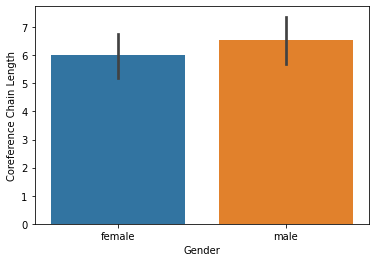

In [27]:
df = defaultdict(list)
for p, info in female_name_to_info.items():
    df['Gender'].append('female')
    df['Coreference Chain Length'].append(len(info['coref_chain']))
for p, info in male_name_to_info.items():
    df['Gender'].append('male')
    df['Coreference Chain Length'].append(len(info['coref_chain']))
df = pd.DataFrame(df)

sns.barplot(data=df, x='Gender', y='Coreference Chain Length')

## Part 2: Plot subject vs. object count by gender

<AxesSubplot:xlabel='Syntactic Type', ylabel='Count'>

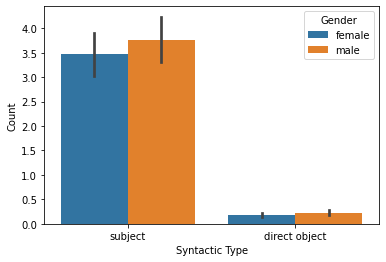

In [28]:
df = defaultdict(list)
for p, info in female_name_to_info.items():
    df['Gender'].append('female')
    df['Count'].append(len(info['nsubj_verb_list']))
    df['Syntactic Type'].append('subject')    
    df['Gender'].append('female')
    df['Count'].append(len(info['dobj_verb_list']))
    df['Syntactic Type'].append('direct object')    
    
for p, info in male_name_to_info.items():
    df['Gender'].append('male')
    df['Count'].append(len(info['nsubj_verb_list']))
    df['Syntactic Type'].append('subject')    
    df['Gender'].append('male')
    df['Count'].append(len(info['dobj_verb_list']))
    df['Syntactic Type'].append('direct object')    

df = pd.DataFrame(df)

sns.barplot(data=df, x='Syntactic Type', y='Count', hue='Gender')

## Part 3: Plot most common verbs for females vs. males when mentioned as a subject

<AxesSubplot:xlabel='Count', ylabel='Verb'>

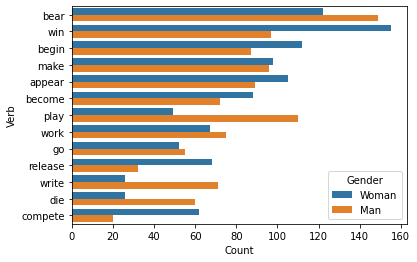

In [29]:
# females mentioned as subject
top_nsubj_verb_f = Counter()
for info in female_name_to_info.values():
    top_nsubj_verb_f += Counter(info['nsubj_verb_list'])

top_nsubj_verb_m = Counter()
for info in male_name_to_info.values():
    top_nsubj_verb_m += Counter(info['nsubj_verb_list'])

# get the top 10 verbs in each for plotting
top_verbs = set([v for v,c in top_nsubj_verb_f.most_common(10)])
top_verbs |= set([v for v,c in top_nsubj_verb_m.most_common(10)])

# sort from most common to least
order = sorted(top_verbs, reverse=True, key=lambda k: top_nsubj_verb_f[k] + top_nsubj_verb_m[k]) 

# make a dataframe for plotting
df = defaultdict(list)
for v in top_verbs:
    df['Verb'].append(v)
    df['Count'].append(top_nsubj_verb_f[v])
    df['Gender'].append('Woman')
    df['Verb'].append(v)
    df['Count'].append(top_nsubj_verb_m[v])
    df['Gender'].append('Man')
df = pd.DataFrame(df)

sns.barplot(data=df, x='Count', y='Verb', hue='Gender', order=order)

## Part 4: Plot most common verbs for females vs. males when mentioned as a direct object

<AxesSubplot:xlabel='Count', ylabel='Verb'>

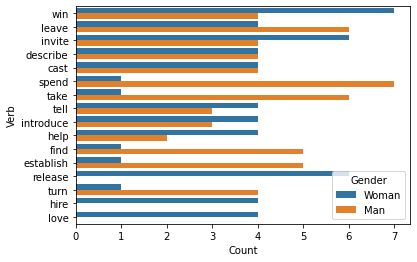

In [30]:
# females mentioned as subject
top_nsubj_verb_f = Counter()
for info in female_name_to_info.values():
    top_nsubj_verb_f += Counter(info['dobj_verb_list'])

top_nsubj_verb_m = Counter()
for info in male_name_to_info.values():
    top_nsubj_verb_m += Counter(info['dobj_verb_list'])

# get the top 10 verbs in each for plotting
top_verbs = set([v for v,c in top_nsubj_verb_f.most_common(10)])
top_verbs |= set([v for v,c in top_nsubj_verb_m.most_common(10)])

# sort from most common to least
order = sorted(top_verbs, reverse=True, key=lambda k: top_nsubj_verb_f[k] + top_nsubj_verb_m[k]) 

# make a dataframe for plotting
df = defaultdict(list)
for v in top_verbs:
    df['Verb'].append(v)
    df['Count'].append(top_nsubj_verb_f[v])
    df['Gender'].append('Woman')
    df['Verb'].append(v)
    df['Count'].append(top_nsubj_verb_m[v])
    df['Gender'].append('Man')
df = pd.DataFrame(df)

sns.barplot(data=df, x='Count', y='Verb', hue='Gender', order=order)

Why might we see the results we're seeing? A few ideas
* Consider _who_ gets a Wikipedia page. Are there any differences in people (or by gender) that would influence these roles?
* Consider how many biographies we see for men and women when we load the data. How might this imbalance in representation influence what we see here?
* What do you think would change if we looked at more results? Since these are just a sample, we're loosely approximating the full distribution. What do you think the full distribution would look like?

## Check the timelines for females and males

Last but not least, we still have the extracted timelines for each person. Let's print out a few to see what people have been up to!

In [31]:
def print_timelines(name_to_info, num=15):
    names = list(name_to_info.keys())[:num]
    for name in names:
        if len(name_to_info[name]['timelines']) == 0:
            print('No recorded events for %s!' % name)
        else:
            print(name + '\'s timeline:')
            for event, year in sorted(name_to_info[name]['timelines'].items(), key=lambda x: x[1]):
                print(year + '\t' + event)
        print('-' * 50)

In [32]:
print_timelines(male_name_to_info)

No recorded events for Jon Davis (poet)!
--------------------------------------------------
No recorded events for Jan Matoušek (rower)!
--------------------------------------------------
No recorded events for Kiril Kiryakov!
--------------------------------------------------
No recorded events for Morgan Lundin!
--------------------------------------------------
No recorded events for Biswajit Chakraborty!
--------------------------------------------------
No recorded events for Christo van Rensburg!
--------------------------------------------------
Henrik Kristoffersen's timeline:
2012	Born in Lørenskog in Akershus county, Kristoffersen made his World Cup debut in March 2012 in Kranjska Gora, Slovenia, and attained his first podium in November 2013, a third-place finish in slalom at Levi, Finland.
2014	At the 2014 Winter Olympics in Sochi, Kristoffersen won the bronze medal in slalom at Rosa Khutor at age 19 to become the youngest male medalist in Olympic alpine skiing history.
201

In [33]:
print_timelines(female_name_to_info)

No recorded events for Chinbatyn Otgontsetseg!
--------------------------------------------------
Rebecca Romijn's timeline:
1972	Romijn was born on November 6, 1972, in Berkeley, California.
1991	Among other jobs, Romijn started her modeling career in 1991.
2004	In 2004 Romijn started dating actor Jerry O'Connell.
2007	In January 2007, Romijn made her first appearance on the ABC series ''Ugly Betty'' as a full-time regular cast member.
2007	In November 2007, Romijn made a guest appearance on the ABC series ''Carpoolers'', where she played the ex-wife of the character Laird, played by her real-life husband Jerry O'Connell.
2008	In April 2008, however, it was reported that Romijn would only be appearing as a recurring character in Season 3 due to a change in direction by the writing staff (aligning, fortuitously enough, with Romijn's pregnancy, which would have been inconsistent with her character's storyline).
2008	Romijn and O'Connell have twin daughters born in 2008.
2009	Romijn star